# RT-DETRv2 Fire-Smoke Detection 기본 학습

## RT-DETRv2 라이브러리 선택 이유
RT-DETRv2는 두 가지 주요 라이브러리로 제공됩니다:

1. **Ultralytics**: 
   - YOLO와 통합된 사용하기 쉬운 인터페이스
   - 간편한 학습/추론 API
   - 실용적인 deployment 지원
   
2. **Transformers (Hugging Face)**: 
   - 원본 연구 논문의 구현에 가까움
   - Transformer 아키텍처에 특화
   - 더 많은 커스터마이징 옵션

이 노트북에서는 **Ultralytics** 버전을 사용합니다 (YOLO와 유사한 워크플로우).

In [1]:
# 필요한 라이브러리 설치
# !pip install -q ultralytics gdown

## 1. 환경 설정 및 라이브러리 임포트

In [15]:
import os, glob, gdown, zipfile
import random
import math
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
file_id = '1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz'
zip_path = 'fire_smoke_detection.zip'

if os.path.exists('fire_smoke_detection.zip'):
    os.remove('fire_smoke_detection.zip')

# Download ZIP into current directory
gdown.download(f'https://drive.google.com/uc?id={file_id}', zip_path, quiet=False)

# Extract into current directory
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall('.')

# Auto-detect data.yaml path
candidates = glob.glob('fire_smoke_detection/data.yaml')
if not candidates:
    raise FileNotFoundError("data.yaml not found after extraction. Check ZIP content.")
data_yaml = candidates[0]
print(f"Using data.yaml: {data_yaml}")

Downloading...
From (original): https://drive.google.com/uc?id=1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz
From (redirected): https://drive.google.com/uc?id=1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz&confirm=t&uuid=1957b29d-78da-48fc-939a-7b2d43d2d002
To: /fire_smoke_detection.zip
100%|██████████| 3.07G/3.07G [00:35<00:00, 86.9MB/s]


Using data.yaml: fire_smoke_detection/data.yaml


In [16]:
# 시각화 유틸 함수: 라벨 있는 이미지들에서 3x3 그리드로 예측 bbox 표시

def visualize_grid(model, image_dir: str, label_dir: str, rows: int = 3, cols: int = 3):
    if not os.path.exists(image_dir):
        raise RuntimeError(f'이미지 디렉토리를 찾을 수 없습니다: {image_dir}')
    if not os.path.exists(label_dir):
        raise RuntimeError(f'라벨 디렉토리를 찾을 수 없습니다: {label_dir}')

    img_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    label_backed = []
    for f in img_files:
        stem = os.path.splitext(f)[0]
        if os.path.exists(os.path.join(label_dir, stem + '.txt')):
            label_backed.append(f)

    if len(label_backed) == 0:
        raise RuntimeError('라벨 파일이 있는 이미지를 찾지 못했습니다.')

    sample_count = min(rows * cols, len(label_backed))
    sample_imgs = random.sample(label_backed, sample_count)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for idx, f in enumerate(sample_imgs):
        img_path = os.path.join(image_dir, f)
        infer_results = model(img_path, verbose=False)
        r = infer_results[0]
        plotted = r.plot()
        axes[idx].imshow(plotted)
        axes[idx].axis('off')
        axes[idx].set_title(f, fontsize=8)

    for k in range(sample_count, rows * cols):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
from ultralytics import RTDETR
import torch

# GPU 확인
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

CUDA Available: True
GPU: NVIDIA A100-PCIE-40GB
CUDA Version: 11.8


## 2. 데이터 경로 및 설정 확인

In [4]:
# 데이터셋 경로 확인
data_yaml = r'fire_smoke_detection/data.yaml'

# 파일 존재 확인
if os.path.exists(data_yaml):
    print(f"✓ 데이터 설정 파일 찾음: {data_yaml}")
    
    # data.yaml 내용 확인
    with open(data_yaml, 'r') as f:
        print("\ndata.yaml 내용:")
        print(f.read())
else:
    print(f"✗ 데이터 설정 파일을 찾을 수 없음: {data_yaml}")

✓ 데이터 설정 파일 찾음: fire_smoke_detection/data.yaml

data.yaml 내용:
# 로컬 환경용 경로 설정 (YAML 파일 기준 상대 경로)
train: data/train/images
val: data/val/images  
test: data/test/images

# Classes
names: ['smoke', 'fire']  # Replace with your actual class names

# Counts
nc: 2  # number of classes
train_count: 14122
val_count: 3099
test_count: 4306



## 3. RT-DETRv2 모델 로드

In [7]:
model = RTDETR('rtdetr-l.pt')

## 4. 기본 학습 (하이퍼파라미터 없음)

In [8]:
# Choose a safe default; bump up if VRAM allows
default_batch = 32
num_workers = 8           # Linux dataloader workers

results = model.train(
    data=data_yaml,
    epochs=50,
    imgsz=640,
    batch=default_batch,
    device=0,
    workers=num_workers,
    cache='ram',
    amp=True,
    patience=10,
    project='rtdetr_fire_smoke',
    name='rtdetrv2',
    exist_ok=True,
    verbose=True,
)
print("\n Training complete.")

Ultralytics 8.3.233 🚀 Python-3.10.18 torch-2.6.0+cu118 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fire_smoke_detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rtdetrv2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=

[W1129 08:03:36.202352652 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.


rt-detr-l summary: 457 layers, 32,810,186 parameters, 32,810,186 gradients, 108.0 GFLOPs

Transferred 926/941 items from pretrained weights
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2669.1±1203.6 MB/s, size: 141.2 KB)
train: Scanning /fire_smoke_detection/data/train/labels.cache... 14122 images, 6458 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 14122/14122 14.7Mit/s 0.0s
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
train: Caching images (16.2GB RAM): 100% ━━━━━━━━━━━━ 14122/14122 1.4Kit/s 10.2s<0.0s
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 613.6±177.3 MB/s, size: 116.8 KB)
val: Scanning /fire_smoke_detection/data/val/labels.cache... 3099 images, 1375 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3099/3099 3.0Mit/s 0.0ss
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consi

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/50      24.3G      0.892      1.649     0.5642         19        640: 100% ━━━━━━━━━━━━ 442/442 1.8it/s 4:02<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.6it/s 13.5s0.3s
                   all       3099       3932      0.589       0.53       0.53      0.269

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/50      24.5G     0.5923     0.8091     0.3252         65        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/50      24.5G     0.6286     0.7048     0.3065         16        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.8s0.3s
                   all       3099       3932      0.638      0.562      0.598      0.293

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/50      24.1G     0.6467     0.6949     0.3143         59        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/50      24.1G     0.7205     0.6379     0.3184         23        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.615       0.52      0.552      0.277

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/50      24.1G      0.706     0.7041     0.2692         67        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/50      24.1G     0.7623     0.6224     0.3272         11        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:54<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.574      0.473      0.502       0.24

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/50      24.2G     0.6055     0.6939     0.3723         71        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/50      24.2G     0.7477     0.6061     0.3181         20        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.8s0.3s
                   all       3099       3932      0.612      0.549      0.575      0.292

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/50      24.2G      0.703     0.6381     0.2538         70        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/50      24.2G     0.7297     0.5998       0.31         33        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.691      0.544      0.598      0.294

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/50      24.2G      1.019      0.493     0.4606         60        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/50      24.2G      0.707     0.5991     0.3008          9        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.675       0.61      0.671      0.352

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/50      24.2G     0.5853     0.7168     0.2735         40        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/50      24.2G     0.7019     0.5915     0.2959         32        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.715      0.612      0.682      0.352

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/50      24.2G     0.7053     0.5411     0.2927         65        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/50      24.2G     0.6919     0.5852     0.2895         16        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.691       0.61      0.668       0.35

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/50      24.2G     0.6422      0.608     0.2876         53        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/50      24.2G     0.6921     0.5724      0.287         20        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:47<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932       0.72      0.618      0.688      0.357

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/50      24.2G     0.7417     0.5645     0.3285         80        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      11/50      24.2G     0.6747     0.5762     0.2815         14        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.712      0.652      0.713      0.386

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/50      24.1G     0.5243     0.6174     0.2811         46        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      12/50      24.1G      0.668     0.5652     0.2789         23        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932        0.7      0.628      0.693      0.364

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/50      24.1G     0.5943     0.7145     0.2516         58        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      13/50      24.1G     0.6507     0.5651     0.2771         18        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.724      0.662      0.719      0.388

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/50      24.1G     0.8458     0.5887     0.2975         62        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      14/50      24.1G      0.641     0.5659     0.2716         30        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.733      0.647      0.716       0.38

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/50      24.3G     0.5793     0.5965     0.2553         77        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      15/50      24.3G     0.6489     0.5666     0.2671         27        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.702      0.641      0.699      0.377

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/50      24.2G     0.7037     0.5153     0.2151         70        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/50      24.2G     0.6389     0.5629     0.2639         17        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.732      0.668       0.73      0.398

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/50      24.1G     0.6412       0.52     0.2803         62        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      17/50      24.1G     0.6191     0.5537     0.2581         25        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.728      0.641      0.706      0.387

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/50      24.1G     0.5776     0.5374      0.223         69        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      18/50      24.1G     0.6178     0.5487     0.2585         25        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.736      0.665      0.732        0.4

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/50      24.3G     0.8011     0.5176     0.2312         99        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      19/50      24.3G     0.6022       0.55     0.2539         21        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.8s0.3s
                   all       3099       3932      0.715       0.66      0.716      0.384

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/50      24.1G     0.6033     0.5329     0.1987         75        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      20/50      24.1G     0.5951     0.5476     0.2549         19        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.755      0.685      0.762      0.424

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/50      24.2G     0.8577     0.5293     0.2742         88        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      21/50      24.2G     0.5946     0.5436     0.2496         13        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.9s0.3s
                   all       3099       3932      0.751      0.667      0.738      0.407

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/50      24.1G      0.443     0.5708     0.2283         55        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      22/50      24.1G     0.5803     0.5461     0.2483         23        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:54<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932       0.74       0.69      0.749       0.42

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/50      24.1G     0.5178     0.5826     0.2661         60        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      23/50      24.1G     0.5708     0.5362     0.2462         18        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:55<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.7it/s 13.1s0.3s
                   all       3099       3932      0.742      0.722       0.76      0.428

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/50      24.1G     0.5178     0.5881     0.2799         65        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      24/50      24.1G     0.5651     0.5317     0.2383         38        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.746      0.703      0.758      0.421

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/50      24.1G     0.6876      0.454     0.2524         59        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      25/50      24.1G     0.5715      0.531     0.2422         31        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.8s0.3s
                   all       3099       3932       0.76      0.694      0.748      0.416

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/50      24.2G     0.4889     0.5463     0.2246         45        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      26/50      24.2G     0.5462     0.5306      0.238         17        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932       0.73       0.72      0.755       0.42

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/50        24G     0.5209      0.552     0.2643         53        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      27/50        24G     0.5524      0.526     0.2346         17        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.8s0.3s
                   all       3099       3932      0.742       0.71      0.761      0.431

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/50      24.2G     0.6067      0.444     0.2023         75        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      28/50      24.2G     0.5501     0.5231      0.232         18        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932       0.75      0.706      0.755      0.419

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/50      24.1G     0.6153     0.6109     0.2727         79        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      29/50      24.1G     0.5551     0.5254     0.2388         22        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.755      0.715      0.762       0.43

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/50      24.1G     0.5785     0.5319     0.2414         68        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      30/50      24.1G     0.5456      0.523     0.2375         20        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.756      0.713      0.766      0.432

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/50      24.2G     0.6025      0.562     0.2433         61        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      31/50      24.2G     0.5462     0.5139     0.2313         21        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.8s0.3s
                   all       3099       3932      0.753      0.719      0.769      0.434

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/50      24.2G     0.5455     0.4379     0.2549         59        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      32/50      24.2G     0.5342      0.515     0.2297         14        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.771      0.714      0.763      0.428

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/50      24.2G     0.4566     0.4807     0.2344         75        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      33/50      24.2G     0.5482      0.525     0.2375         36        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.7it/s 13.2s0.3s
                   all       3099       3932      0.751      0.725      0.768      0.431

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/50      24.1G     0.5037     0.5183     0.1769         46        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      34/50      24.1G     0.5444     0.5272      0.238         23        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:54<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.755      0.725      0.767      0.433

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/50      24.1G     0.5236     0.5149     0.2447         48        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      35/50      24.1G     0.5501     0.5312     0.2484         16        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.764      0.717       0.76       0.43

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/50      24.1G     0.5646     0.5766     0.2781         63        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      36/50      24.1G     0.5407     0.5231     0.2368         18        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.772      0.727      0.769       0.43

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/50      24.2G     0.6211     0.4872     0.2416         64        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      37/50      24.2G     0.5088     0.5342     0.2252         23        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.763        0.7      0.756       0.43

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/50      24.2G     0.4935     0.5155     0.2078         93        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      38/50      24.2G     0.5232      0.507       0.23         29        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:54<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.772      0.724      0.773      0.435

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/50      24.3G     0.5728     0.5103     0.1683         48        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      39/50      24.3G     0.4969     0.4974     0.2178          9        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.8s0.3s
                   all       3099       3932      0.762      0.719      0.759      0.426

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/50        24G     0.5949     0.4614     0.2239         64        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      40/50        24G     0.4931     0.4926      0.215         37        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:54<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.9s0.3s
                   all       3099       3932      0.759      0.716      0.756      0.424
Closing dataloader mosaic

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/50      23.8G     0.5253     0.4602      0.269         67        640: 0% ──────────── 0/442  0.7s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      41/50      23.8G     0.4965     0.4746      0.226          8        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932       0.77      0.711       0.76      0.431

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/50      24.1G      0.386     0.4003     0.1677         33        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      42/50      24.1G     0.4753     0.4823     0.2156         11        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.7s0.3s
                   all       3099       3932      0.771      0.698      0.753      0.429

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/50      24.2G     0.3523     0.3994     0.2756         30        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      43/50      24.3G     0.4676     0.4733     0.2112          8        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.774      0.721      0.762      0.435

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/50        24G     0.3932     0.4482      0.152         58        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      44/50        24G      0.458     0.4929     0.2048         10        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:54<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.722      0.679      0.718      0.413

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/50      24.2G     0.5517     0.5104     0.1153         33        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      45/50      24.2G     0.4607     0.5082     0.2023          7        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.9s0.3s
                   all       3099       3932      0.686      0.666      0.692      0.399

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/50      24.1G     0.3655     0.5154     0.1685         42        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      46/50      24.1G     0.4327     0.5142     0.1938         15        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.7s0.3s
                   all       3099       3932      0.686      0.652      0.684      0.397

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/50      24.3G     0.3992      0.545     0.1891         41        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      47/50      24.3G       0.43     0.5311     0.1867         16        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.9s0.3s
                   all       3099       3932      0.662       0.64      0.669      0.388

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      48/50      24.3G     0.3449     0.5498     0.2016         35        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      48/50      24.3G     0.4175     0.4919     0.1819         10        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.689      0.646      0.678      0.394

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      49/50      24.2G     0.3455      0.453      0.165         32        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      49/50      24.3G      0.408     0.4459     0.1766         12        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 13.0s0.3s
                   all       3099       3932      0.701      0.676      0.701        0.4

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      50/50      24.1G     0.3975     0.4732     0.1567         36        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      50/50      24.1G     0.3969     0.4407     0.1682          6        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.721       0.68      0.709      0.406

50 epochs completed in 3.421 hours.
Optimizer stripped from /rtdetr_fire_smoke/rtdetrv2/weights/last.pt, 66.2MB
Optimizer stripped from /rtdetr_fire_smoke/rtdetrv2/weights/best.pt, 66.2MB

Validating /rtdetr_fire_smoke/rtdetrv2/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.10.18 torch-2.6.0+cu118 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.7it/s 13.3s0.3s
                   all       3099       3932      0.772       0.72      0.762      0.435
           

## 5. 검증 데이터셋 평가 (mAP, Precision, Recall)

In [9]:
# 검증 데이터셋에서 모델 평가 (mAP, precision, recall 등)
metrics = model.val(
    data=data_yaml,
    batch=32,   # 훈련에 사용한 batch와 동일하게 맞추기
    device=0,
    name='rtdetr_val',
    project='rtdetr_fire_smoke',
    verbose=True
)

print("\n[평가 결과]")
print(metrics)

Ultralytics 8.3.233 🚀 Python-3.10.18 torch-2.6.0+cu118 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1936.3±1259.0 MB/s, size: 208.8 KB)
val: Scanning /fire_smoke_detection/data/val/labels.cache... 3099 images, 1375 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3099/3099 3.3Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 4.5it/s 21.6s0.2ss
                   all       3099       3932      0.776      0.716      0.762      0.436
                 smoke       1550       1756      0.802      0.797      0.821      0.499
                  fire        879       2176      0.751      0.635      0.703      0.373
Speed: 0.5ms preprocess, 4.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /rtdetr_fire_smoke/rtdetr_val

[평가 결과]
ultralytics.utils.metrics.DetMetrics object with attr

### 5-1. 탐지 결과 시각화 (bbox 포함)

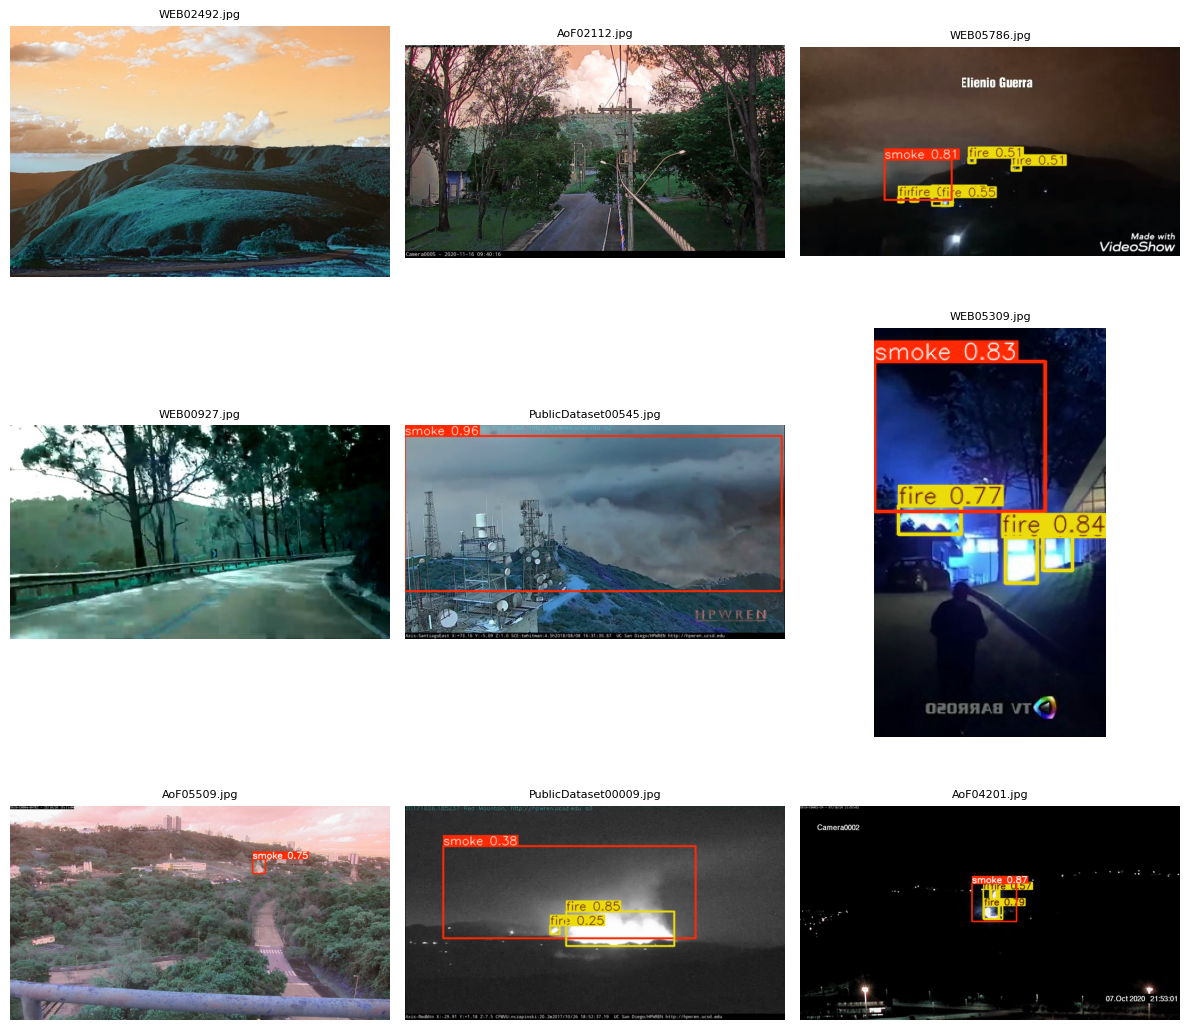

In [17]:
# 3x3 그리드 탐지 시각화 (bbox 포함)

val_img_dir = 'fire_smoke_detection/data/val/images'
val_lbl_dir = 'fire_smoke_detection/data/val/labels'

visualize_grid(model, val_img_dir, val_lbl_dir, rows=3, cols=3)

## 6. 테스트셋 평가 (mAP 등)

In [18]:
# 테스트 데이터셋에서 모델 평가 (mAP, precision, recall 등)
test_metrics = model.val(
    data=data_yaml,
    split='test',  # 테스트셋 평가
    batch=32,
    device=0,
    name='rtdetr_test',
    project='rtdetr_fire_smoke',
    verbose=True
)
print("\n[테스트셋 평가 결과]")
print(test_metrics)

Ultralytics 8.3.233 🚀 Python-3.10.18 torch-2.6.0+cu118 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2064.2±1097.8 MB/s, size: 190.4 KB)
val: Scanning /fire_smoke_detection/data/test/labels... 4306 images, 2005 backgrounds, 4 corrupt: 100% ━━━━━━━━━━━━ 4306/4306 1.2Kit/s 3.6s0.0ss
val: /fire_smoke_detection/data/test/images/WEB10769.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0296875]
val: /fire_smoke_detection/data/test/images/WEB10775.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.015625]
val: /fire_smoke_detection/data/test/images/WEB11243.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test/images/WEB11244.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test/images/WEB11245.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test

### 6-1. 탐지 결과 시각화 (bbox 포함)

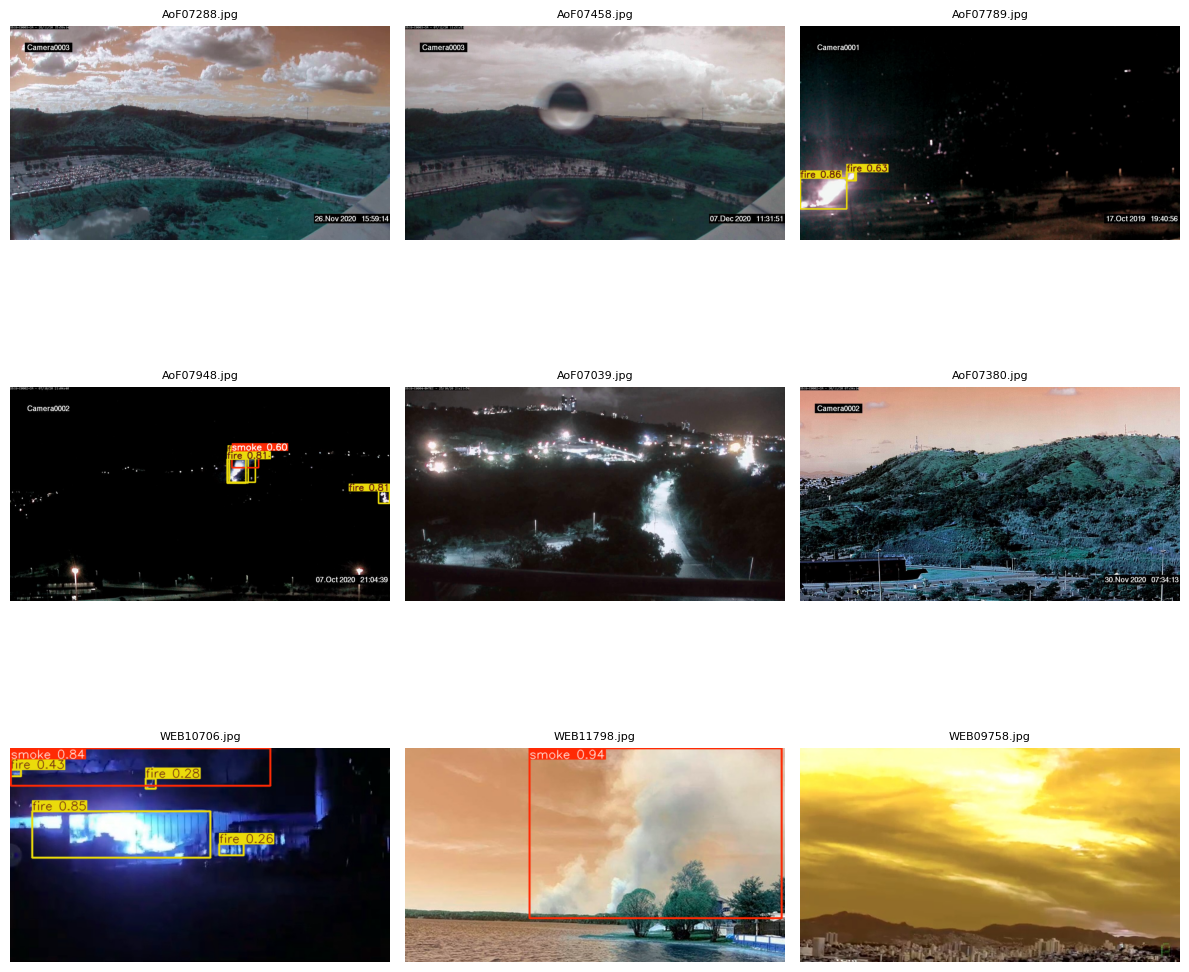

In [19]:
# 테스트셋 3x3 그리드 탐지 시각화 (bbox 포함)

test_img_dir = 'fire_smoke_detection/data/test/images'
test_lbl_dir = 'fire_smoke_detection/data/test/labels'

visualize_grid(model, test_img_dir, test_lbl_dir, rows=3, cols=3)